<img src="https://i.imgur.com/12tfKrD.png" alt="Alin">
</img>


# Demo RNN -- 張愛玲散文集AI二次創作

資料集: 張愛玲繁體中文小說 《傳奇》

爬蟲來源: [crawl_book](https://colab.research.google.com/drive/1f_HvQEvgkJPFc473TlA-I_3EmkThA2SR?usp=sharing)

程式碼參考: [Tensorflow](https://www.tensorflow.org/tutorials/text/text_generation)

本次資料集，著作權乃是張愛玲女士所擁有。**請勿將本次資料集散播、更改、用於非商業用途**。

> **資料集說明**

今年是張愛玲女士101年誕辰。張愛玲出生名門，曾就讀於香港大學和聖約翰大學，受過良好的中西教育。上海淪陷時期，陸續發表《沉香屑·第一爐香》、《傾城之戀》、《心經》、《金鎖記》等中、短篇小說，震動上海文壇。

這次訓練取張愛玲散文集《傳奇》作為訓練，《傳奇》收留五篇散文: 「留情」、「鴻鸞禧」、「紅玫瑰與白玫瑰」、「等」、「桂花蒸阿小悲秋」。其中以「紅玫瑰與白玫瑰」最為膾炙人口。

> **訓練步驟**

深度學習在訓練模型上有以下幾個重要的步驟:
1. 讀入相關封包
2. 取得資料集 
3. 資料前處理
4. 建立模型
5. 制定訓練計畫
6. 評估模型
7. 做預測

> **本次模型介紹 RNN**

![](https://i.imgur.com/FaY50C8.png)


我們來看看維度，很多人會搞不懂RNN的維度:

一個Seq通過RNN後的維度

* Input: (Seq,${originDim}$)
* RNN Neuron: 2048
* Output: (Seq,2048) if (return_sequence == True) else (1,2048)
![](https://i.imgur.com/9SVl6JR.png)

![](https://i.imgur.com/z4ElFIr.png)

**把生成問題變成分類問題**

![](https://i.imgur.com/TBHKuf6.png)


In [ ]:
# ****************************************
# **請勿將本次資料集散播、用於非商業用途**
# ****************************************

# 執行即代表同意將會合法、合理使用資料集

!wget -O Eileen_Legendary.txt "http://140.115.82.54/NN/Recurrent/Eileen_Legendary.txt"

--2021-04-12 02:33:26--  http://140.115.82.54/NN/Recurrent/Eileen_Legendary.txt
Connecting to 140.115.82.54:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 818352 (799K) [text/plain]
Saving to: ‘Eileen_Legendary.txt’

Eileen_Legendary.tx 100%[===================>] 799.17K   304KB/s    in 2.6s    

2021-04-12 02:33:29 (304 KB/s) - ‘Eileen_Legendary.txt’ saved [818352/818352]



## 1. 讀入Package

In [ ]:
import numpy as np
import tensorflow as tf
import pandas as pd
from tensorflow import keras
from tensorflow.keras import layers
import os
import matplotlib.pyplot as plt

## 2. 取得資料集

In [ ]:
# 作業之一就是試試看其他本小說

book = ""
with open("./twodragon.txt","r",encoding="utf8") as file:
  for line in file:
    book += line

book_length = len(book)
unique_words = set(book)
print(f"黃易 的 大唐雙龍傳 共有 {book_length} 字詞")
print(f"包含了 {len(unique_words)} 個獨一無二的字 (含標點符號)\n")
print(book[0:500])

黃易 的 大唐雙龍傳 共有 930941 字詞
包含了 3991 個獨一無二的字 (含標點符號)


《二○一七年一月六日版》
《好讀書櫃》典藏版
卷四十九 第一章 矛盾之爭
寇仲和徐子陵的震駭是有理由的，因為這是他們最害怕的事。上趟到長安尋找楊公寶庫，如被揭破，還可與高占道等人立即撤走，可是今趟卻是牽連廣泛，榮達大押的陳甫等人固是首當其衝，追查起來，平遙的歐良材等人亦難免禍。且際此李淵正深忌李世民的當兒，可能李靖也將有難，所以他們於此時分看到窗外的婠婠，立即三魂不齊，七魄不整。
在這方面的掩飾，他們非常小心，用盡手段，想不到終被婠婠識破，最糟是直到此刻他們仍不曉得漏子出在那裏？更聯想到婠婠既可如此，暗伺在旁的石之軒自可辦到。兩人頭皮發麻，啞口無言時，婠婠從窗外飄進來，毫不客氣的坐到床端，嘴角含春的道：「兩位情郎好！你們的考慮有結果嗎？」
寇仲正面向著她，深吸一口氣以舒緩震駭波動的情緒，沉聲道：「妳是怎樣發覺的？」徐子陵改變坐姿，雙目電射婠婠，心忖現在唯一的解決辦法，就是希望婠婠乃唯一曉得「司徒福榮計劃」的人，然後合兩人之力不擇手段拚著受傷來個殺人滅口，否則以後會被她牽著鼻子走。他肯定寇仲心中轉的是同一念頭，他不知道寇仲能否狠下此心，卻知自己肯定辦不到。
婠婠香肩微聳，輕鬆的道：「百


## 3. 資料前處理

文字前處理有一堆方法、作法:
* 切字
* 還原
* 清除特殊字符
* 清除不常見字符 (StopWord)


我這裡僅使用去除不常見的字(StopWord)

In [ ]:
# 計算字數統計
words_count = {}
for w in book:
  if w in words_count:
    words_count[w] += 1
  else:
    words_count[w] = 1

words_count = sorted(words_count.items(),key=lambda x:x[1])

In [ ]:
stop_word = 8
unique_words = [w_tup[0] for w_tup in words_count if w_tup[1]>stop_word]
print(f"去除次數小於{stop_word}的文字剩餘 : {len(unique_words)}")

去除次數小於8的文字剩餘 : 2634


In [ ]:
print(f"原本 大唐雙龍傳 共有 {book_length} 字詞")
print(f"去除不常出現的文字後")
book = [w for w in book if w in unique_words]
print(f"剩餘{len(book)}個字")

原本 大唐雙龍傳 共有 930941 字詞
去除不常出現的文字後
剩餘926576個字


In [ ]:
# 文字轉數字(index)
word_2_index = {word:index for index,word in enumerate(unique_words)}
index_2_word = {word_2_index[word]:word for word in word_2_index}

book_2_index = [word_2_index[w] for w in book]

print("原始文字 : ")
print(book[:40])
print("-"*40)
print("轉成index : ")
print({word_2_index[w] for w in book[:40]})

原始文字 : 
['\n', '《', '二', '一', '七', '年', '一', '月', '六', '日', '》', '\n', '《', '好', '讀', '書', '櫃', '》', '典', '藏', '\n', '卷', '四', '十', '九', '第', '一', '章', '矛', '盾', '之', '爭', '\n', '寇', '仲', '和', '徐', '子', '陵', '的']
----------------------------------------
轉成index : 
{386, 2564, 1808, 1428, 2335, 420, 2088, 2602, 2606, 2609, 1075, 2612, 2615, 2616, 2618, 957, 2622, 2624, 2246, 1863, 2632, 2122, 1867, 2007, 862, 2400, 1507, 1508, 1765, 2284, 2291, 2167, 2170}


In [ ]:
def ind2word_seq(seq):
  return [index_2_word[i] for i in seq]

In [ ]:
# 設定輸入模型長度
seq_len = 20
characters = tf.data.Dataset.from_tensor_slices(book_2_index)
# characters = characters.map(lambda w:word_2_index[w.item()])

sequences = characters.batch(seq_len+1,drop_remainder=True)

for seq in sequences.take(2):
  print(seq.shape)
  print(seq)
  print([index_2_word[i] for i in seq.numpy()])

(21,)
tf.Tensor(
[2622 1507 2284 2624 1428 2167 2624 2170 1808 2246 1508 2622 1507 2564
  386 1863  420 1508  862 2007 2622], shape=(21,), dtype=int32)
['\n', '《', '二', '一', '七', '年', '一', '月', '六', '日', '》', '\n', '《', '好', '讀', '書', '櫃', '》', '典', '藏', '\n']
(21,)
tf.Tensor(
[1075 2335 2400 2122 2088 2624  957 1867 1765 2606 2291 2622 2616 2615
 2602 2609 2618 2612 2632 2216 1497], shape=(21,), dtype=int32)
['卷', '四', '十', '九', '第', '一', '章', '矛', '盾', '之', '爭', '\n', '寇', '仲', '和', '徐', '子', '陵', '的', '震', '駭']


![](https://i.imgur.com/YMVMFEJ.png)


In [ ]:
# 做input、target切割
def split_input_target(seq):
  input_txt = seq[:-1]
  target_txt = seq[1:]
  return input_txt,target_txt

split_input_target(list("Tensorflow"))

(['T', 'e', 'n', 's', 'o', 'r', 'f', 'l', 'o'],
 ['e', 'n', 's', 'o', 'r', 'f', 'l', 'o', 'w'])

![](https://i.imgur.com/YoHWLkf.png)


In [ ]:
dataset = sequences.map(split_input_target)

for input_example,target_exaple in dataset.take(1):
  print("Input :", ind2word_seq(input_example.numpy()))
  print("Target:", ind2word_seq(target_exaple.numpy()))
  print("-"*50)
  print("Input :", input_example.numpy())
  print("Target:", target_exaple.numpy())

Input : ['\n', '《', '二', '一', '七', '年', '一', '月', '六', '日', '》', '\n', '《', '好', '讀', '書', '櫃', '》', '典', '藏']
Target: ['《', '二', '一', '七', '年', '一', '月', '六', '日', '》', '\n', '《', '好', '讀', '書', '櫃', '》', '典', '藏', '\n']
--------------------------------------------------
Input : [2622 1507 2284 2624 1428 2167 2624 2170 1808 2246 1508 2622 1507 2564
  386 1863  420 1508  862 2007]
Target: [1507 2284 2624 1428 2167 2624 2170 1808 2246 1508 2622 1507 2564  386
 1863  420 1508  862 2007 2622]


In [ ]:
# 建立資料集
# Batch size
BATCH_SIZE = 64

BUFFER_SIZE = 10000

dataset = (
    dataset
    .shuffle(BUFFER_SIZE)
    .batch(BATCH_SIZE, drop_remainder=True))

dataset

<BatchDataset shapes: ((64, 20), (64, 20)), types: (tf.int32, tf.int32)>

## 4. 建立模型

![](https://i.imgur.com/TBHKuf6.png)

In [ ]:
# 超參數
EMBEDDING_DIM = 512

# 使用 keras 建立一個非常簡單的 LSTM 模型
model = tf.keras.Sequential()

model.add(
  tf.keras.layers.Embedding(
    input_dim=len(unique_words), 
    output_dim=EMBEDDING_DIM
))

model.add(
  tf.keras.layers.LSTM(
    units=4096, 
    return_sequences=True, 
))

model.add(
  tf.keras.layers.LSTM(
    units=2048, 
    return_sequences=True,
))
  
model.add(
  tf.keras.layers.Dense(
      len(unique_words),activation="softmax"))

model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, None, 512)         1348608   
_________________________________________________________________
lstm_2 (LSTM)                (None, None, 4096)        75513856  
_________________________________________________________________
lstm_3 (LSTM)                (None, None, 2048)        50339840  
_________________________________________________________________
dense_1 (Dense)              (None, None, 2634)        5397066   
Total params: 132,599,370
Trainable params: 132,599,370
Non-trainable params: 0
_________________________________________________________________


In [ ]:
# 查看模型的輸入、輸出 shape
for input_example,target_exaple in dataset.take(1):
  predict_example = model(input_example)
  print(f"Model input shape : {input_example.shape}")
  print(f"Model output shape : {predict_example.shape}")
  print(f"Model target shape : {target_exaple.shape}")

Model input shape : (64, 20)
Model output shape : (64, 20, 2634)
Model target shape : (64, 20)


In [ ]:
print("原本的中文字序列：")
[print(index_2_word[ind],end="") for ind in input_example[0].numpy()]
print()
print("-"*40)
print("輸入尚未訓練的model後獲得：")
print()

predict_words = tf.math.argmax(predict_example[0],-1)
[print(index_2_word[ind],end="") for ind in predict_words.numpy()]
print()

原本的中文字序列：
次馳想幽林小谷是怎樣一處人間勝地，直至此
----------------------------------------
輸入尚未訓練的model後獲得：

德童童童童癸癸癸癸癸愁愁袍袍遞流虛秀秀秀


## 5. 制定訓練計畫並訓練

* [sparse_categorical_crossentropy](https://www.tensorflow.org/api_docs/python/tf/keras/losses/sparse_categorical_crossentropy) V.S. [categorical_crossentropy](https://www.tensorflow.org/api_docs/python/tf/keras/losses/categorical_crossentropy)

```python=
# categorical_crossentropy
y_true = [[0, 1, 0], [0, 0, 1]]
y_pred = [[0.05, 0.95, 0], [0.1, 0.8, 0.1]]
assert loss.shape == (2,)

# sparse_categorical_crossentropy
y_true = [1, 2]
y_pred = [[0.05, 0.95, 0], [0.1, 0.8, 0.1]]
assert loss.shape == (2,)

```


In [ ]:
model.compile(loss="sparse_categorical_crossentropy",optimizer="adam")

In [ ]:
EPOCHS = 20
history = model.fit(
    dataset, # 前面使用 tf.data 建構的資料集
    epochs=EPOCHS,
)

Epoch 1/20
689/689 [==============================] - 249s 358ms/step - loss: 6.0378
Epoch 2/20
689/689 [==============================] - 247s 358ms/step - loss: 4.7095
Epoch 3/20
689/689 [==============================] - 247s 359ms/step - loss: 4.2271
Epoch 4/20
689/689 [==============================] - 247s 359ms/step - loss: 3.8979
Epoch 5/20
689/689 [==============================] - 247s 358ms/step - loss: 3.6023
Epoch 6/20
689/689 [==============================] - 247s 358ms/step - loss: 3.3088
Epoch 7/20
689/689 [==============================] - 247s 359ms/step - loss: 2.9840
Epoch 8/20
689/689 [==============================] - 247s 359ms/step - loss: 2.6185
Epoch 9/20
689/689 [==============================] - 247s 359ms/step - loss: 2.2152
Epoch 10/20
689/689 [==============================] - 247s 358ms/step - loss: 1.7870
Epoch 11/20
689/689 [==============================] - 247s 359ms/step - loss: 1.3720
Epoch 12/20
689/689 [==============================] - 247s 359

## 6. 衡量模型

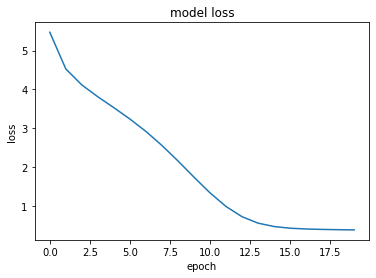

In [ ]:
plt.plot(history.history['loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')

plt.show()

In [ ]:
after_train_predictions = model(input_example)
after_sampled_indices = tf.argmax(after_train_predictions[0],1)

print("原本的中文字序列：")
[print(index_2_word[ind],end="") for ind in input_example[0].numpy()]
print()
print("-"*40)
print("輸入進訓練後的model後獲得：")
print()

[print(index_2_word[ind],end="") for ind in after_sampled_indices.numpy()]
print()

原本的中文字序列：
次馳想幽林小谷是怎樣一處人間勝地，直至此
----------------------------------------
輸入進訓練後的model後獲得：

見想幽林小谷是怎樣一處人間勝地，直至此刻


## 7. 做預測

![](https://i.imgur.com/YsOj6Mw.png)

在實際生成文字時，我們會想要增加一些隨機性。比如”天天出去” 不加入隨機 “天天天天” 如果我們全部輸出的字都是取softmax最大可能性，則一個訓練完美的model會把整本書給輸出出來。但是我們要的是，希望電腦在最大可能性的幾個字中隨機挑選一個字出來。

tf.random.categorical 會根據softmax機率後隨機挑選字，但是我們不希望因為模型很爛導致不合理的字被選中，因此我們會除上一個temperature來增加可能字的比重。

EX: "天天出去" 預測下一個字
1. 玩 : 0.3 
2. 天 : 0.1 
3. 浪 : 0.4 

"天"有的機率被印出，我們不希望。所以我們可以在每一個機率除上一個temperature(0.01)
1. 玩 : 30 
2. 天 : 10 
3. 浪 : 40 
原本"浪"跟"天"差0.3，除temperature後差30



In [ ]:
# 預測文字，並把預測文字循環當作下一次的輸入

# 設定你的temperature
temperature = 0.01

def generateWords(input,words=500):
  [print(index_2_word[ind],end="") for ind in input]
  for i in range(words):
    next_input = tf.expand_dims(input,axis=0)
    predicts = model(next_input)
    predicts = predicts[:,-1,:]
    predicts /= temperature
    result = tf.random.categorical(
        predicts,num_samples=1
    )
    chinese_ind = tf.squeeze(result).numpy()
    print(index_2_word[chinese_ind],end="")
    input = input+[chinese_ind]
    input = input[-seq_len:]

In [ ]:
init_seq = "石青璇苦笑"
init_seq_ind = [word_2_index[w] for w in init_seq]
input = init_seq_ind[-seq_len:]

generateWords(input,600)

石青璇苦笑道：「我不是不想當皇帝。」
徐子陵一呆道：「竟有此事？」
雲玉真點頭道：「我今天雖是一針見血的見老哥，不過這可怕現在既然對方絕無的事。」
寇仲道：「我們亦有一件事請你幫忙。」
沈落雁撫著胸口，一手一字道：「他怎能不付楊虛彥？」
侯希白笑道：「我和子陵因何欲意見雷大哥，老天爺仍一命去見她。」徐子陵欣然道：「難怪子陵會告訴我她，卻是你的情況。」寇仲欣然道：「難怪子陵剛才大叫不好。」
寇仲信心十足的道：「我們是否真的對這裏來？」
徐子陵道：「我們可經由水路往一塊兒送送你們，到那裏去？」
跋鋒寒失聲道：「我今晚來，是要代李世民說服他？」跋鋒寒頹然道：「這叫愛夫情切嘛！」
徐子陵立即精神大振，道：「這方面朕交由少帥全權負責，應是塞外聯軍南下的非常時期，從軍事角度考慮，李世民閉上帝位。」
寇仲向韋公公道：「有甚麼好打算？」
劉黑闥沉聲道：「我要去見李世民。」
寇仲大吃一驚道：「喜兒妳尚未有意中人嗎？」陰顯鶴老臉通紅的道：「她不是說過的嗎？」
傅君瑜淡淡道：「若我沒有猜錯，傅采林是否要到長安來？」徐子陵笑道：「你有把握穿透對方的人，我會盡力而為，好卻好！我們今趟來是要全力運作出來的軍事行動，你們怎可如此魯莽，難道不曉得大唐宮中人殺人，且是默許建成、元吉的人，所以能對任何人更清楚答案。
沈落雁細審他神色，黛眉輕蹙道：「大帥曉得此人叫要看醒，若是福榮爺的人。」
頓頓續道：「我曾為劉弘基方面都沒有問題

## 作業2.1 (30%)

使用[爬蟲程式](https://colab.research.google.com/drive/1f_HvQEvgkJPFc473TlA-I_3EmkThA2SR?usp=sharing)來取得一個新的文本資料集，或是不管你從哪裡取得的資料集也可以(不要再張愛玲了，不限中英文)。然後丟入這個模型來看看AI生成文字的成果，將**結果**與**你的心得**(不是機器產生的心得)，貼上pdf。

請隨意修改本colab的模型與參數來達到更好的結果。

資料集越有趣越好，比如你可以去爬PTT文章來製作廢文產生器。去爬Dcard製作幻想文產生器。